In [53]:
using LatinHypercubeSampling
using Surrogates
using Plots
using LinearAlgebra
import Random
using MLBase
using LaTeXStrings
using Measures
include("gridsamp.jl")
Random.seed!(1234);

In [54]:
lb = [-2.0,-2.0]
ub = [2.0,2.0]
n_samples = 200;

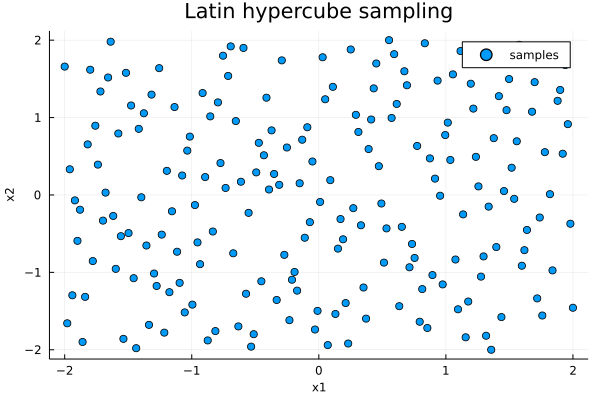

In [55]:
plan, _ = LHCoptim(n_samples,2,1000);
lhs = scaleLHC(plan,[(lb[1],ub[1]),(lb[2],ub[2])])
plot(lhs[:,1], lhs[:,2], seriestype = :scatter, label = "samples", title = "Latin hypercube sampling")
xlabel!("x1", xguidefontsize=8)
ylabel!("x2", yguidefontsize=8)

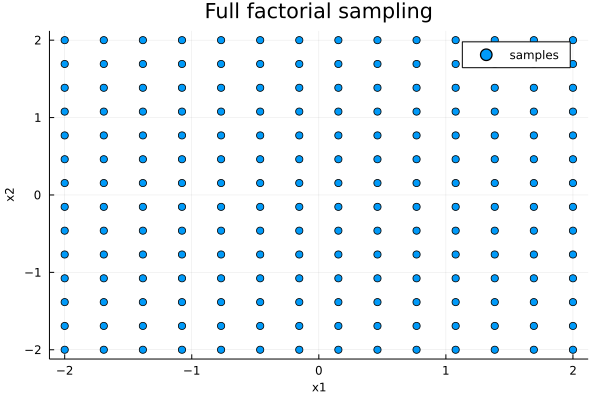

In [56]:
bounds = Matrix{Float64}(undef,2,2)
bounds[1,:] = lb
bounds[2,:] = ub

n_levels = [Int(round(sqrt(n_samples))),Int(round(sqrt(n_samples)))]
full_fact = gridsamp(bounds,n_levels)
plot(full_fact[:,1], full_fact[:,2], seriestype = :scatter, label = "samples", title = "Full factorial sampling")
xlabel!("x1", xguidefontsize=8)
ylabel!("x2", yguidefontsize=8)

In [57]:
# convert 2D matrix rows to Tuples
function toTuple(A::Array{T,2}) where {T<:Any}
    return [tuple(A[c,:]...) for c in 1:size(A,1)]
end

function rosenbrock(x)
    z = (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
end

z = mapslices(rosenbrock,lhs; dims=2)

# train the model
kriging_surrogate = Kriging(toTuple(lhs), vec(z), lb, ub, p=[2.0, 2.0], theta=[0.03, 0.003]);

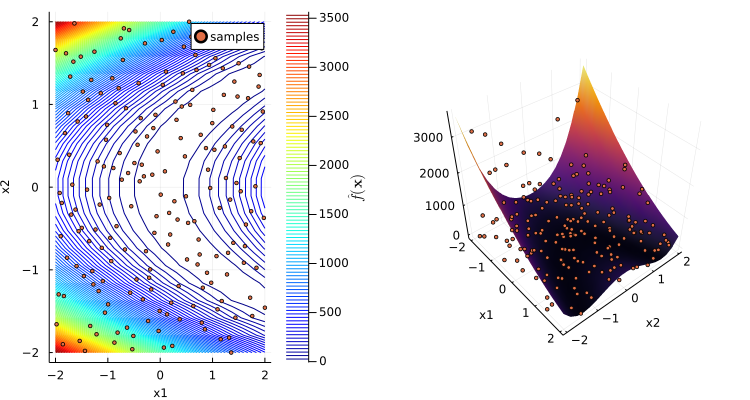

In [72]:
bounds_s = Matrix{Float64}(undef,2,2)
bounds_s[1,:] = lb
bounds_s[2,:] = ub
n_grids = 20
ns = [n_grids,n_grids]
Xs = gridsamp(bounds_s,ns)

# Predictions
zs = kriging_surrogate.(toTuple(Xs))
xs = LinRange(bounds_s[1,1],bounds_s[2,1],n_grids)
ys = LinRange(bounds_s[1,2],bounds_s[2,2],n_grids)

# contour plot
p1 = contour(xs, ys, vec(zs), fill = false, levels = 100, c = :jet1, colorbar_title=L"\hat{f}(\mathbf{x})", colorbar_titlefontsize = 10)
scatter!(lhs[:,1], lhs[:,2], seriestype = :scatter, label = "samples", markersize=2);
xlabel!("x1", xguidefontsize=8)
ylabel!("x2", yguidefontsize=8)


# Surface plot
p2 = plot(xs, ys, vec(zs),st=:surface,camera=(50,40), colorbar_title=L"\hat{f}(\mathbf{x})", legend = :none)
scatter3d!(lhs[:,1], lhs[:,2], vec(zs), label = "samples", markersize=2);
xlabel!("x1", xguidefontsize=8)
ylabel!("x2", yguidefontsize=8)

# combined plot
plot(p1, p2, size = (750, 400), layout = grid(1, 2, widths=[0.5 ,0.5]))

In [59]:
function KfoldCV(X::AbstractMatrix,Y::AbstractMatrix,n_folds::Int64,θ::Float64)::Float64
    
    rows = collect(Kfold(size(lhs)[1],n_folds))

    MSE = 0
    for fold in rows
        # train the model
        kriging_surrogate = Kriging(toTuple(X[fold,:]), vec(Y[fold]), lb, ub, p=[2.0, 2.0], theta=[θ, θ]);
    
        # Predictions
        test = deleteat!([1:1:size(X)[1];], fold)
        Y_predict = kriging_surrogate.(toTuple(X[test,:]))
    
        # error
        MSE += norm(Y_predict - Y[test])
    end
    
    MSE /= n_folds
end

error_θ = [KfoldCV(lhs,z,5,θ) for θ=1e-2:5e-3:1e-0];

In [60]:
function error_sampling(X::AbstractMatrix,Y::AbstractMatrix,n::Int64)::Float64
    n = min(160,n) # cap n at 160

    # train the model
    kriging_surrogate = Kriging(toTuple(X[1:n,:]), vec(Y[1:n]), lb, ub, p=[2.0, 2.0], theta=[0.03, 0.03]);

    # Predictions
    Y_predict = kriging_surrogate.(toTuple(X[160:end,:]))

    # error
    MSE = norm(Y_predict - Y[160:end])
end

error_n = [error_sampling(lhs,z,n) for n=20:2:160];

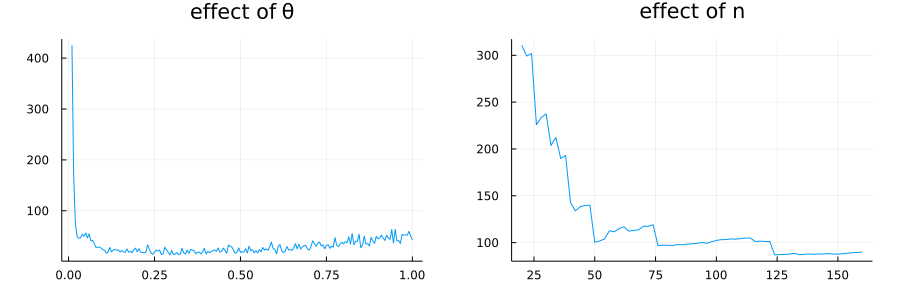

In [61]:
# theta plot
p1 = plot(1e-2:5e-3:1e-0, error_θ, st=:line, title="effect of \\theta" );

# samples plot
p2 = plot(20:2:160, error_n, st=:line, title="effect of n");

# combined plot
plot(p1, p2, size = (900, 300), layout = grid(1, 2, widths=[0.5 ,0.5]), legend=false, margin=5mm)